In [1]:
import numpy as np
import pandas as pd
import os
import re
from collections import Counter
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from transformers import pipeline
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import nltk 
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
class DataLoader:

    def __init__(self, data_path = "bbc"):
        """Инициализация процессора текстовых данных."""
        self.data_path = data_path
        self.documents = []
        self.labels = []
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self._load_data()
        
    def _load_data(self):
        """Загружает текстовые данные из указанной директории."""
        for root, _, files in os.walk(self.data_path):
            for file in files:
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='latin-1') as f:
                    text = f.read().strip()
                    self.documents.append(text)
                    self.labels.append(os.path.basename(root))
        
        self.df = pd.DataFrame({'text': self.documents,'label': self.labels})
    
    def preprocess_text(self, text):
        """Очищает и лемматизирует текст."""
        text = re.sub(r"[^a-zA-Z'\s]", '', text.lower())
        
        tokens = word_tokenize(text)
        processed_tokens = [
            self.lemmatizer.lemmatize(token) for token in tokens 
            if token not in self.stop_words and len(token) > 2
        ]
        
        return ' '.join(processed_tokens)
    
    
    def vectorize_data(self, texts, max_features=9000, lang = 'english'):
        """Векторизует обработанные тексты с использованием TF-IDF и Count методов."""
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words=lang
        )
        tfidf_matrix = tfidf_vectorizer.fit_transform(processed_texts)
        
        count_vectorizer = CountVectorizer(
            max_features=max_features,
            stop_words=lang
        )
        count_matrix = count_vectorizer.fit_transform(processed_texts)
        
        return tfidf_vectorizer, tfidf_matrix, count_vectorizer, count_matrix

In [4]:
class TopicModelingEngine:
    def __init__(self, text_data):
        """Инициализация движка тематического моделирования."""
        self.text_data = text_data
        
    def _calculate_coherence(self, topics):
        """Вычисляет когерентность тем."""
        tokenized_texts = [text.split() for text in self.text_data.df['text'].tolist()]
        dictionary = Dictionary(tokenized_texts)
        coherence_model = CoherenceModel(
            topics=topics,
            texts=tokenized_texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        return coherence_model.get_coherence()
    
    def train_lsi_model(self, count_matrix, vectorizer, num_topics = 5):
        """Обучает LSI модель."""
        lsi = TruncatedSVD(n_components=num_topics, random_state=42)
        lsi.fit(count_matrix)
        
        feature_names = vectorizer.get_feature_names_out()
        topics = []
        
        for topic in lsi.components_:
            top_indices = topic.argsort()[:-11:-1]
            top_words = [feature_names[i] for i in top_indices]
            top_weights = [topic[i] for i in top_indices]
            topics.append((top_words, top_weights))
        
        coherence = self._calculate_coherence([t[0] for t in topics])
        
        return {
            'topics': topics,
            'coherence': coherence,
            'model': lsi
        }
    
    def train_lda_model(self, tfidf_matrix, vectorizer, num_topics = 5):
        """Обучает LDA модель."""
        lda = LatentDirichletAllocation(
            n_components=num_topics,
            random_state=42,
        )
        lda.fit(tfidf_matrix)
        
        feature_names = vectorizer.get_feature_names_out()
        topics = []
        
        for topic in lda.components_:
            top_indices = topic.argsort()[:-11:-1]
            top_words = [feature_names[i] for i in top_indices]
            top_weights = [topic[i] for i in top_indices]
            topics.append((top_words, top_weights))
        
        coherence = self._calculate_coherence([t[0] for t in topics])
        perplexity = lda.perplexity(tfidf_matrix)
        
        return {
            'topics': topics,
            'coherence': coherence,
            'perplexity': perplexity,
            'model': lda
        }

In [5]:
class BertClusterer:
    def __init__(self, model_name = 'all-mpnet-base-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        self.kmeans = None
        self.embeddings = None
        
    def train_BERT(self, texts, n_clusters = 5):
        """Выполняет кластеризацию текстов с использованием BERT-эмбеддингов и K-means."""
        self.embeddings = self.model.encode(texts, show_progress_bar=True)
        
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = self.kmeans.fit_predict(self.embeddings)
        
        silhouette_avg = silhouette_score(self.embeddings, clusters)
        calinski_harabasz = calinski_harabasz_score(self.embeddings, clusters)
        
        return clusters, self.embeddings, silhouette_avg, calinski_harabasz

In [6]:
class TextSummarizer:
    def __init__(self, model_name="facebook/bart-large-cnn"):
        self.model_name = model_name
        self.generative_summarizer = pipeline("summarization", model=model_name)
        
    def summarize_text_extractive(self, text, num_sentences = 5):
        """Экстрактивная суммаризация текста с использованием TextRank и TF-IDF."""
        sentences = sent_tokenize(text)
        
        if len(sentences) <= num_sentences:
            return text
            
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(sentences)
        
        similarity_matrix = cosine_similarity(tfidf_matrix)
        nx_graph = nx.from_numpy_array(similarity_matrix)
        scores = nx.pagerank(nx_graph)
        
        ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        selected_sentences = [s for _, s in ranked_sentences[:num_sentences]]
        
        return ' '.join(selected_sentences)
    
    def summarize_text_generative(self, text, max_length = 130, min_length = 30):
        """Генеративная суммаризация текста с использованием предобученной модели."""
        summary = self.generative_summarizer(text, max_length=max_length, min_length=min_length)
        return summary[0]['summary_text']
    
    def summarize_text(self, text, max_length = 130, min_length = 30, use_extractive_first = True):
        """Комбинированная суммаризация текста."""
        if use_extractive_first:
            # Сначала экстрактивная, затем генеративная суммаризация
            extractive_summary = self.summarize_text_extractive(text)
            return self.summarize_text_generative(extractive_summary, max_length=max_length, min_length=min_length)
        else:
            # Только генеративная суммаризация
            return self.summarize_text_generative(text, max_length=max_length, min_length=min_length)

In [7]:
class TopicVisualizer:
    def visualize_word_weights(self, topics, title):
        """Визуализирует веса слов для каждого топика в виде горизонтальных барплотов"""
        plt.figure(figsize=(12, 6))
        plt.suptitle(title)
        
        for i, (words, weights) in enumerate(topics):
            plt.subplot(2, 3, i + 1)
            plt.barh(words, weights)
            plt.title(f"Topic {i + 1}")
            plt.xlabel("Weight")
        plt.tight_layout()
        plt.show()
    
    def visualize_tsne(self, embeddings, labels, perplexity = 30, title = None):
        """Визуализирует эмбеддинги с использованием t-SNE проекции в 2D пространство."""
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_results = tsne.fit_transform(embeddings)
        
        unique_labels = sorted(set(labels))
        label_to_num = {label: i for i, label in enumerate(unique_labels)}
        numeric_labels = [label_to_num[label] for label in labels]
        
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            tsne_results[:, 0], 
            tsne_results[:, 1], 
            c=numeric_labels, 
            cmap='viridis', 
            edgecolors='w',
            linewidth=0.5
        )
        
        cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
        cbar.set_label('Category', rotation=270, labelpad=20)
        
        plt.title(title or 't-SNE Visualization of Embeddings', pad=20)
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.show()

In [8]:
class TopicsModeling:
    def __init__(self, data_dir = "bbc"):
        """Класс для комплексного анализа тем в новостных данных."""
        self.data_dir = data_dir
        self.data_loader = DataLoader(data_dir)
        self.topic_modeler = TopicModelingEngine(self.data_loader)
        self.bert = BertClusterer()
        self.summarizer= TextSummarizer()
        self.visualizer = TopicVisualizer()

    def topic_analyze(self, topic, n_topics = 5):
        """Анализирует указанную тему с помощью LSI, LDA и BERT-кластеризации."""
        print(f"Analyzing topic: {topic}")

        # Получаем тексты для выбранной темы
        topic_texts = self.data_loader.df[self.data_loader.df['label'] == topic]['text'].tolist()
        
        # Подготовка данных
        tfidf_vectorizer, tfidf_matrix, count_vectorizer, count_matrix = self.data_loader.vectorize_data(topic_texts)

        # LSI анализ
        lsi_results = self.topic_modeler.train_lsi_model(tfidf_matrix, tfidf_vectorizer, n_topics)
        print(f"\nLSI Results for '{topic}':")
        print(f"Coherence Score: {lsi_results['coherence']:.4f}")
        self.visualizer.visualize_word_weights(
            lsi_results['topics'], 
            title=f"Word Weights - LSI ({topic})"
        )

        # LDA анализ
        lda_results = self.topic_modeler.train_lda_model(count_matrix, count_vectorizer, n_topics)
        print(f"\nLDA Results for '{topic}':")
        print(f"Coherence Score: {lda_results['coherence']:.4f}")
        print(f"Perplexity: {lda_results['perplexity']:.4f}")
        self.visualizer.visualize_word_weights(
            lda_results['topics'], 
            title=f"Word Weights - LDA ({topic})"
        )

        # BERT кластеризация
        clusters, embeddings, silhouette_avg, calinski_harabasz = self.bert.train_BERT(topic_texts, n_topics)
        print(f"\nBERT Clustering Results for '{topic}':")
        print(f"Silhouette Score: {silhouette_avg:.4f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
        self.visualizer.visualize_tsne(
            embeddings, 
            clusters, 
            title=f"t-SNE Visualization - BERT Clustering ({topic})"
        )

        print(f"\nСуммаризация для категории {topic}:")
        combined_text = ' '.join(topic_texts) 
        summary = self.summarizer.summarize_text(combined_text)
        print(summary)
        print()
        print('-------------------------------------------------')  

    def all_topic_analysis(self, n_topics = 5):
        """Анализирует все темы в наборе данных."""
        topics = self.data_loader.df['label'].unique()
        
        for topic in topics:
            self.topic_analyze(topic, n_topics)

Device set to use cuda:0


Analyzing topic: business

LSI Results for 'business':
Coherence Score: 0.5921


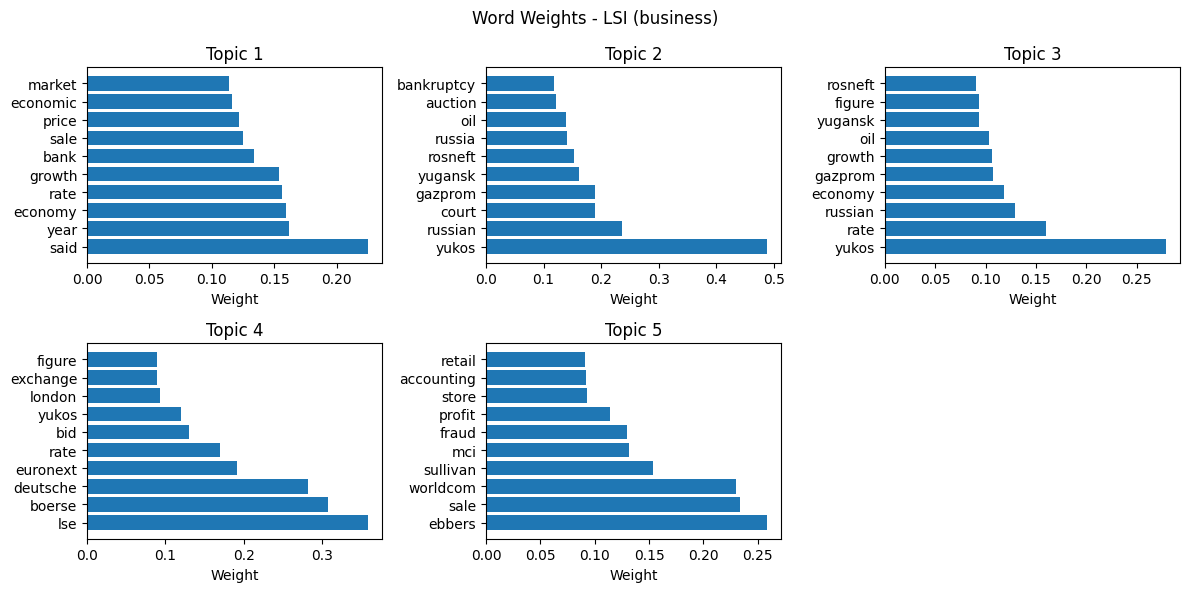


LDA Results for 'business':
Coherence Score: 0.5019
Perplexity: 2725.8900


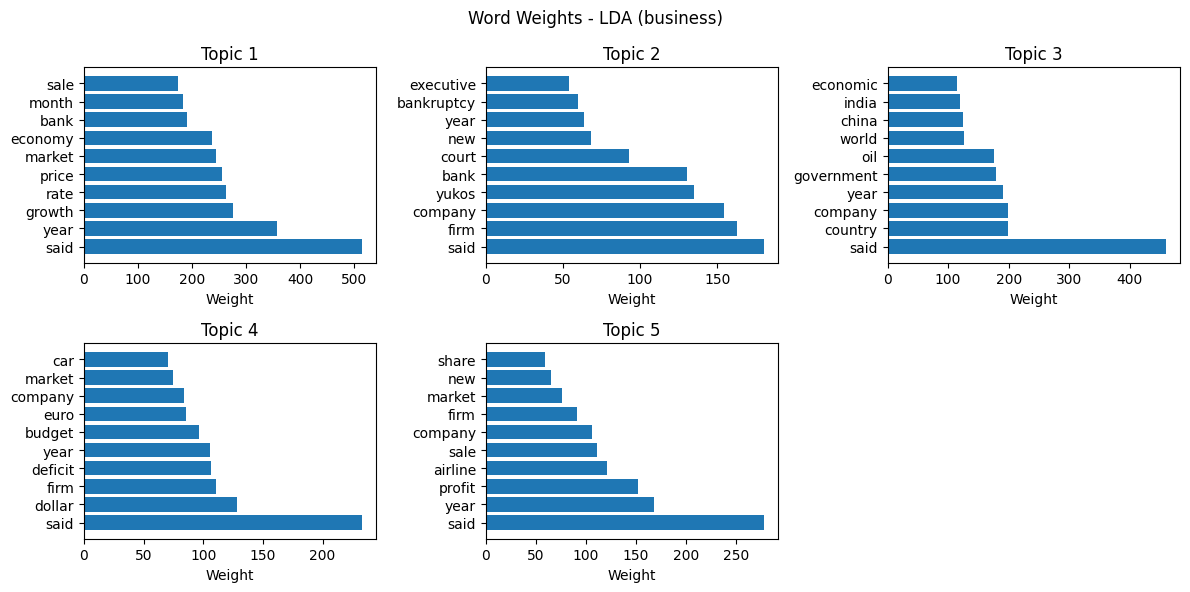

Batches:   0%|          | 0/16 [00:00<?, ?it/s]


BERT Clustering Results for 'business':
Silhouette Score: 0.0540
Calinski-Harabasz Index: 19.9558


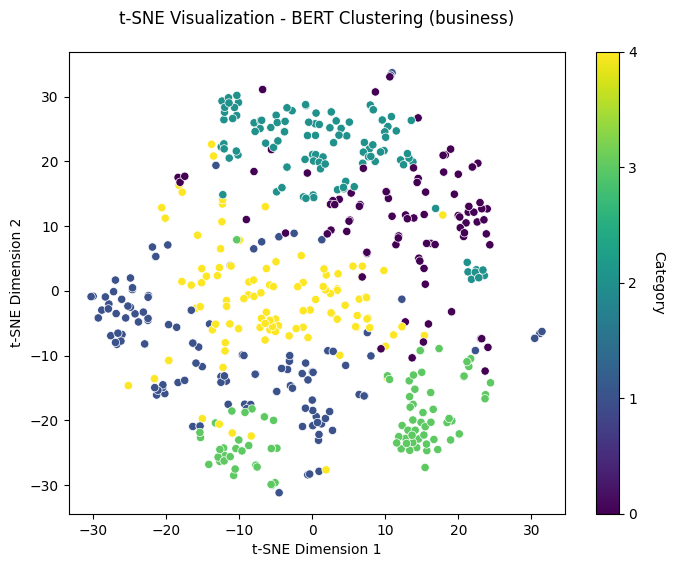


Суммаризация для категории business:
Growth was at an annual rate of 4% in the third quarter of 2004 and for the year it came in at 4.4%. Sales were down more than 25% from the previous year to 1.4bn rupees.

-------------------------------------------------
Analyzing topic: entertainment

LSI Results for 'entertainment':
Coherence Score: 0.6118


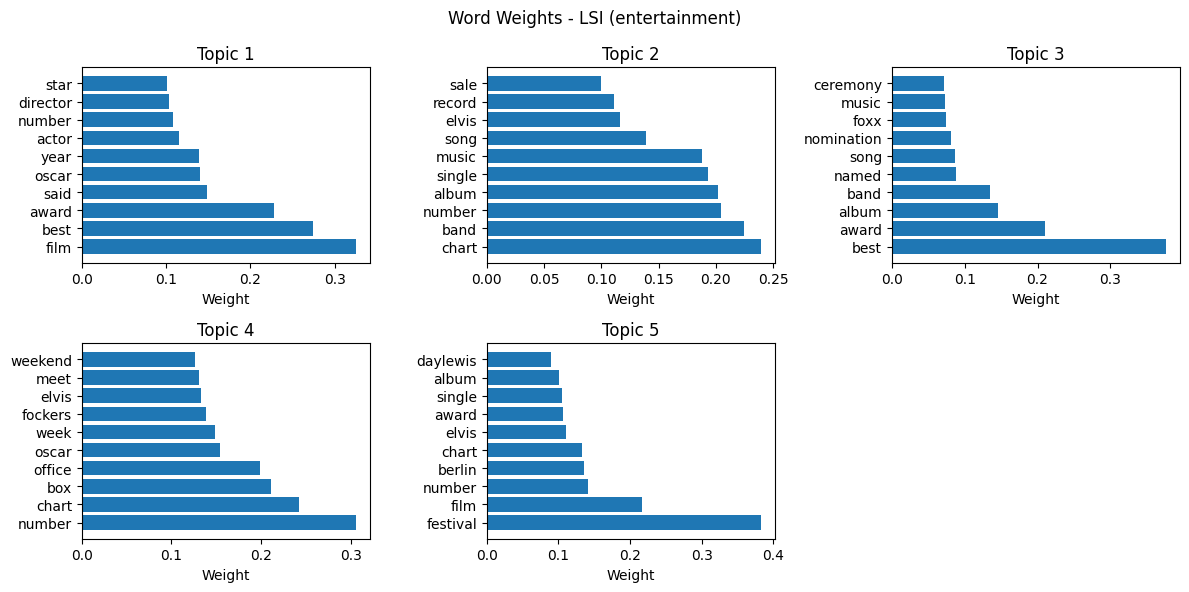


LDA Results for 'entertainment':
Coherence Score: 0.4927
Perplexity: 3236.9926


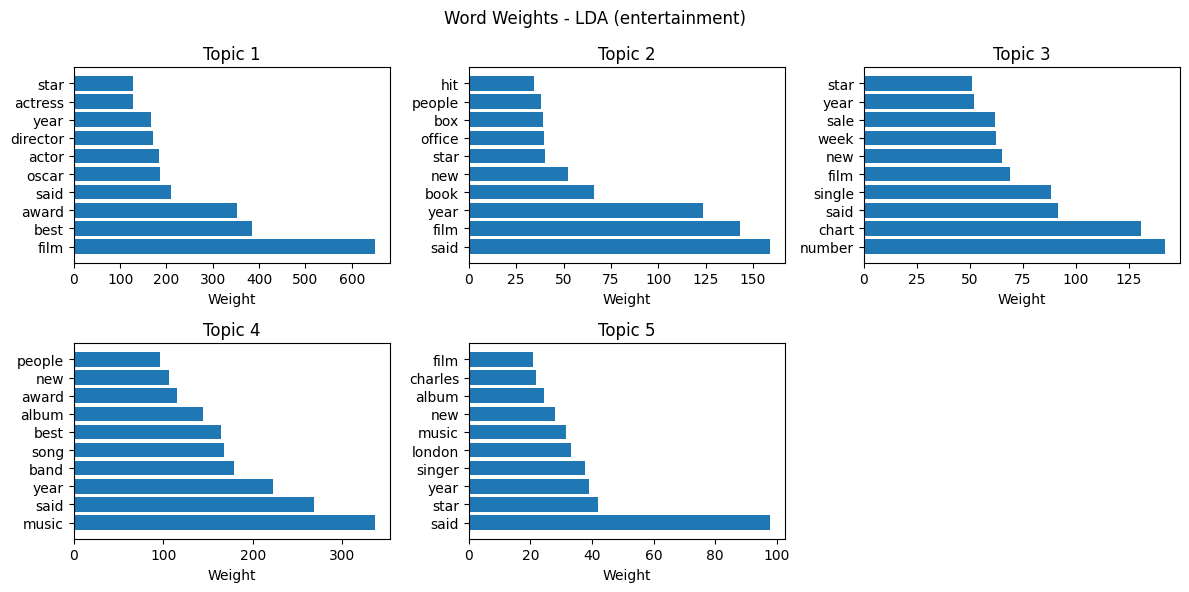

Batches:   0%|          | 0/13 [00:00<?, ?it/s]


BERT Clustering Results for 'entertainment':
Silhouette Score: 0.0253
Calinski-Harabasz Index: 12.7956


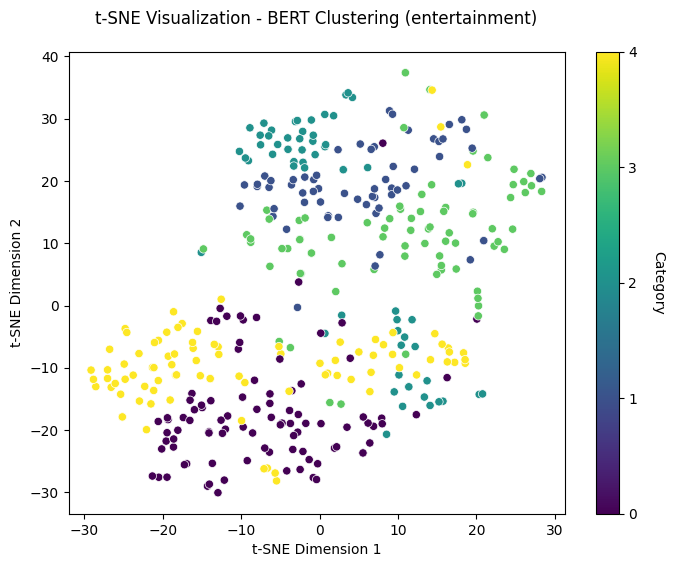


Суммаризация для категории entertainment:
Original stage production of The Sound of Music is to be performed for the first time in the Austrian capital. The move is the biggest shake-up in the history of the show, which was first broadcast in 1964 and has always been on BBC One.

-------------------------------------------------
Analyzing topic: politics

LSI Results for 'politics':
Coherence Score: 0.5188


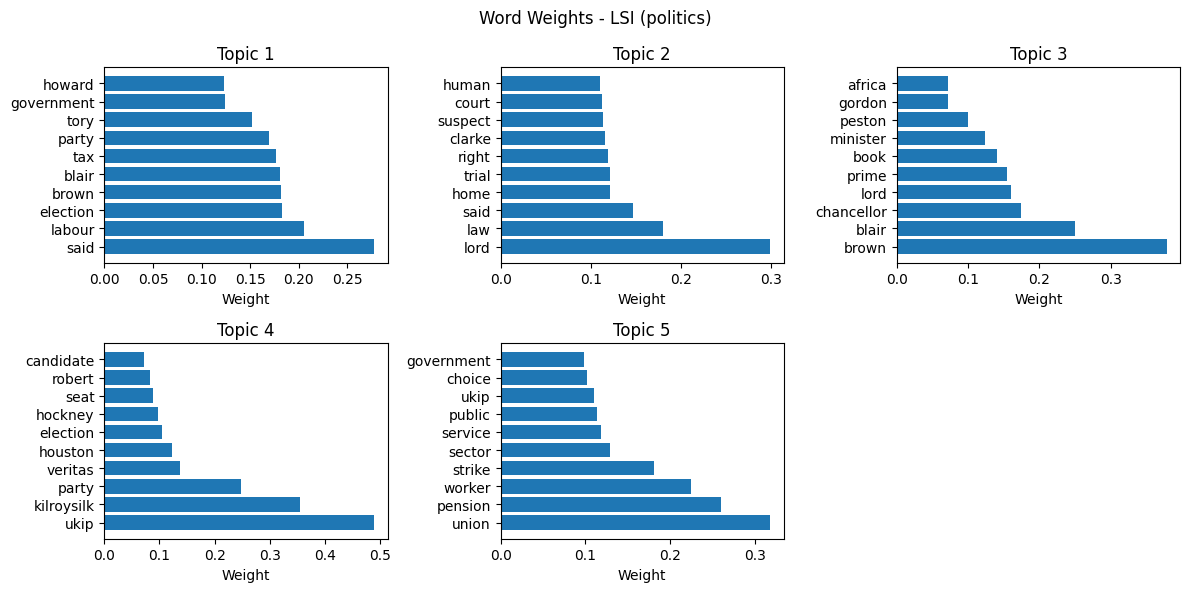


LDA Results for 'politics':
Coherence Score: 0.3945
Perplexity: 2544.0371


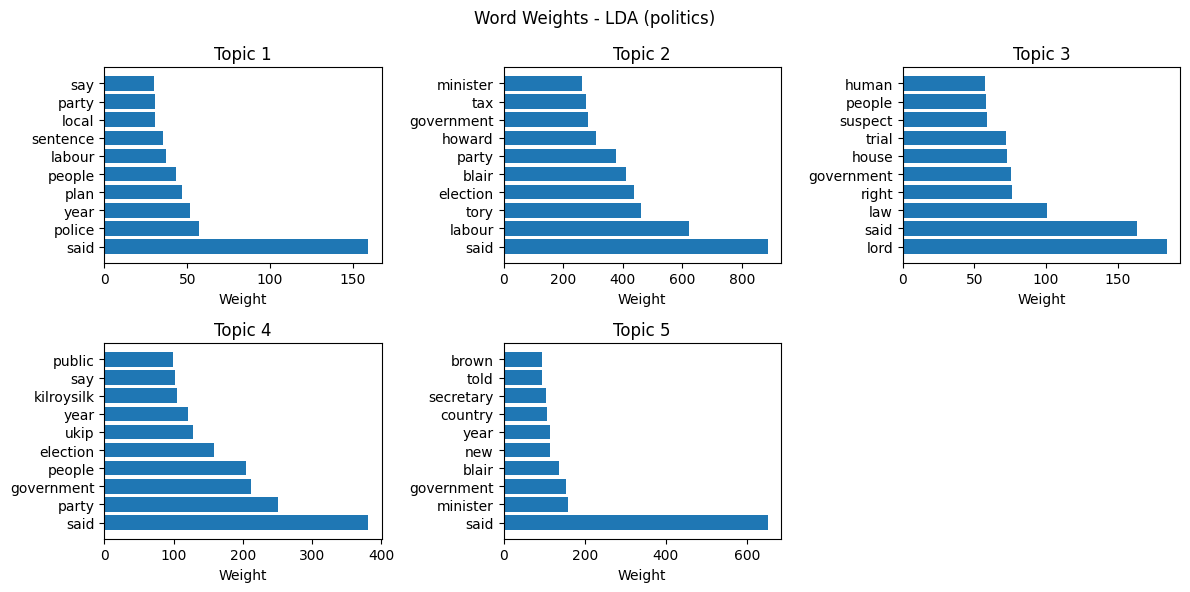

Batches:   0%|          | 0/14 [00:00<?, ?it/s]


BERT Clustering Results for 'politics':
Silhouette Score: 0.0400
Calinski-Harabasz Index: 14.4412


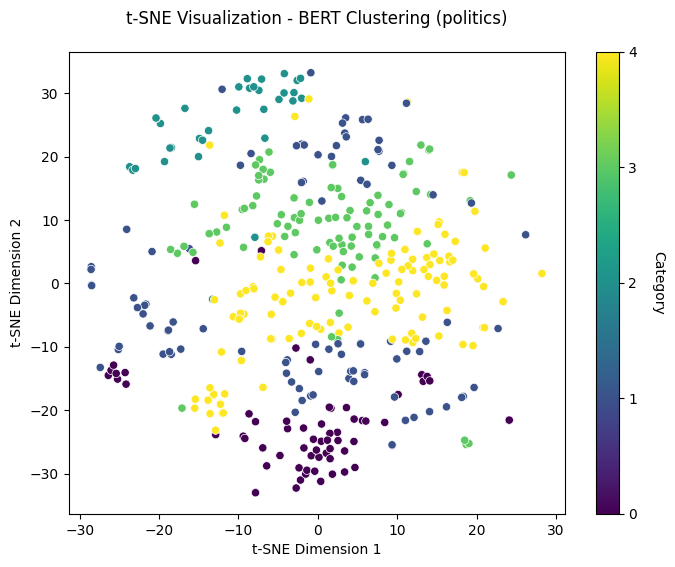


Суммаризация для категории politics:
Tories believe Tony Blair is using the issue to suggest the Tories are soft on terrorism. It is the latest in a series of events designed to show the prime minister is speaking directly to voters.

-------------------------------------------------
Analyzing topic: sport

LSI Results for 'sport':
Coherence Score: 0.5213


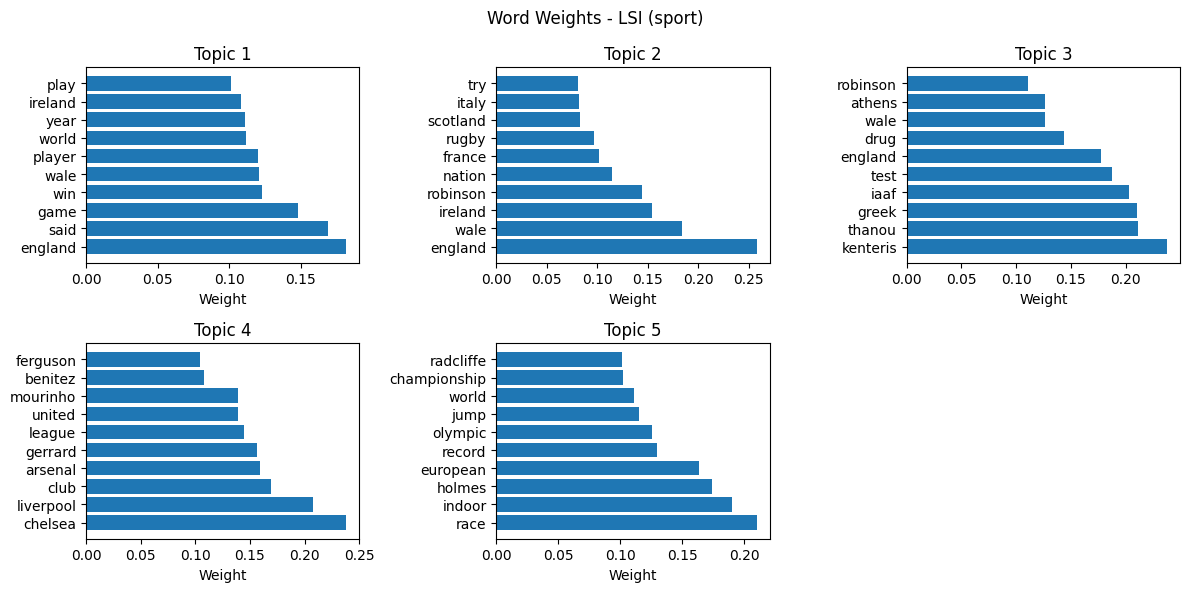


LDA Results for 'sport':
Coherence Score: 0.3846
Perplexity: 2714.0030


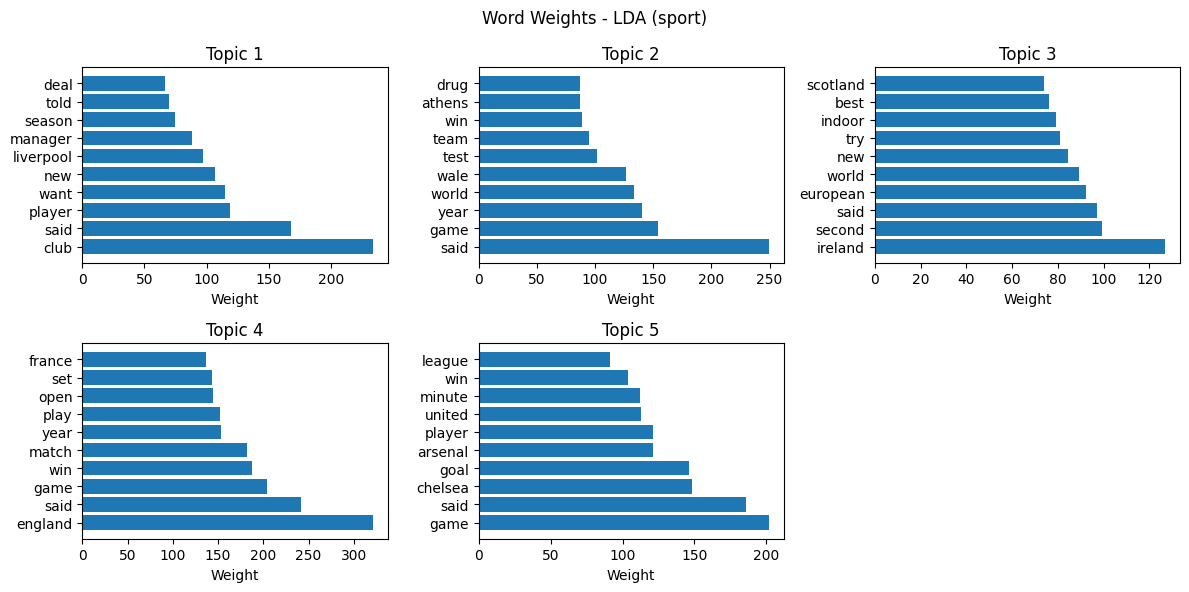

Batches:   0%|          | 0/16 [00:00<?, ?it/s]


BERT Clustering Results for 'sport':
Silhouette Score: 0.1199
Calinski-Harabasz Index: 46.3663


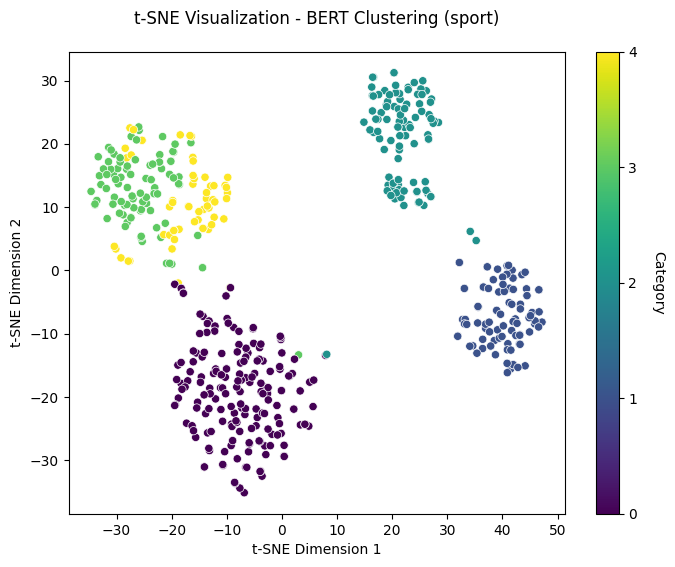


Суммаризация для категории sport:
"We are upset now, but the referee is in charge and he has called it his way and we have got to be able to cope with that," he said. "At the minute, we are at the top of the league and still in with a chance of staying in Europe, so I don't think it is the crisis people have been trying to make out," he added.

-------------------------------------------------
Analyzing topic: tech

LSI Results for 'tech':
Coherence Score: 0.5010


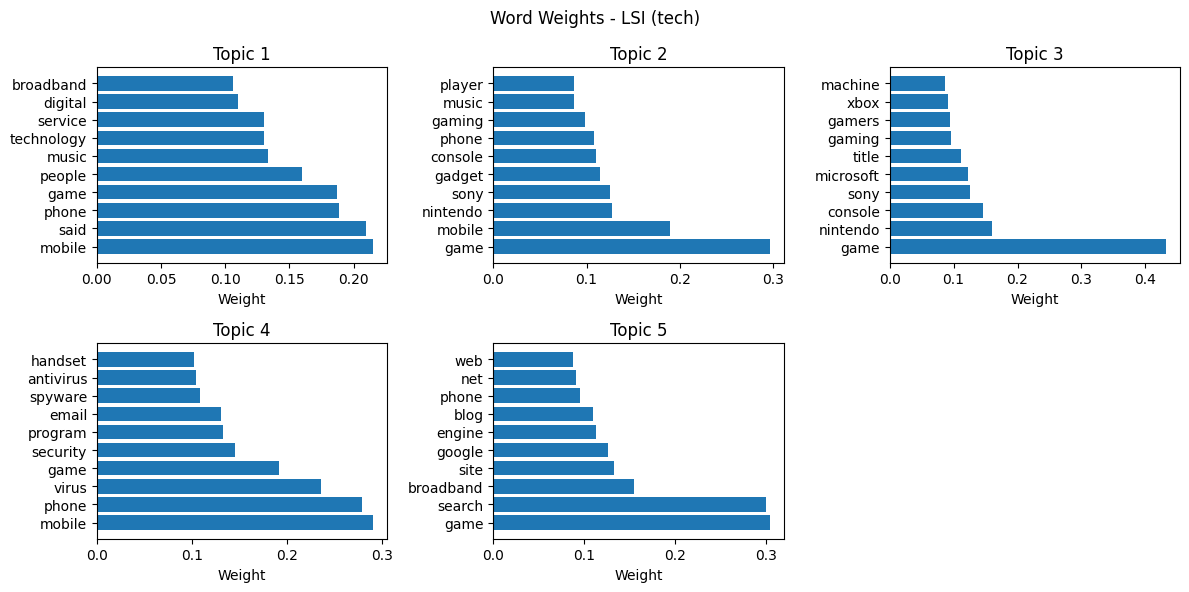


LDA Results for 'tech':
Coherence Score: 0.4525
Perplexity: 2561.3476


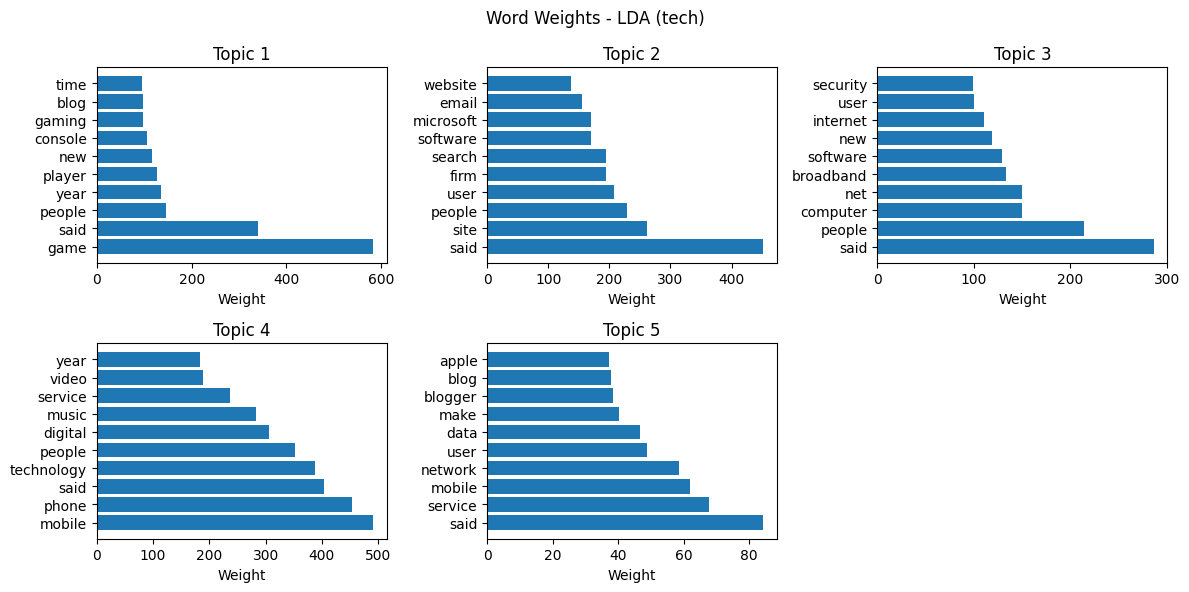

Batches:   0%|          | 0/13 [00:00<?, ?it/s]


BERT Clustering Results for 'tech':
Silhouette Score: 0.0637
Calinski-Harabasz Index: 17.1459


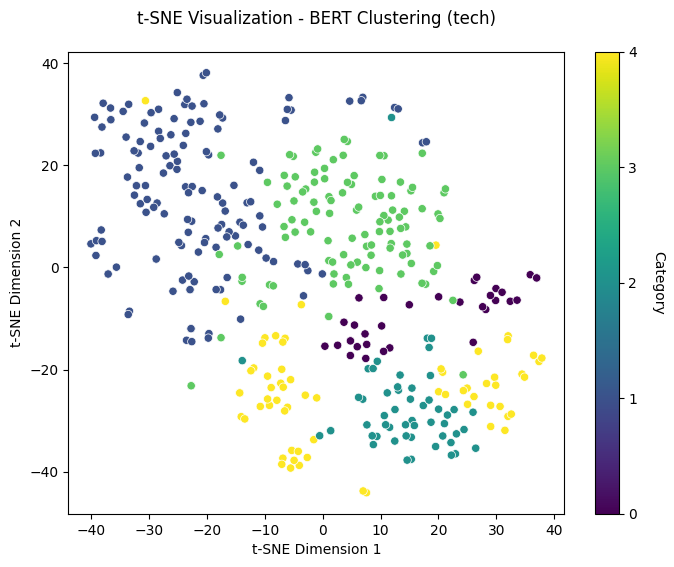


Суммаризация для категории tech:
The Porsche radio is set to go on sale at the end of January in the US and in the first quarter of 2005 in the UK. He said the products which will be making waves in the next year will be about the "democratisation" of content.

-------------------------------------------------


In [9]:
topic_modeling = TopicsModeling("bbc")
topic_modeling.all_topic_analysis(n_topics=5)

## Выводы

### Категория: Business

LSI vs LDA
- LSI Coherence Score: 0.6054  
- LDA Coherence Score: 0.5301  
- LDA Perplexity: 2423.4320  
LSI показывает лучшую тематическую связность. Темы, полученные с помощью LSI, логичнее и семантически цельнее. Высокая perplexity у LDA указывает на её слабую предсказательную способность.

Кластеризация BERT
- Silhouette Score: 0.0540  
- Calinski-Harabasz Index: 19.96  
Кластеры плохо разделены. Вероятно, тексты слишком схожи по смыслу, и модель не смогла выделить устойчивые группы.

Суммаризация
- Кратко охватывает ключевые события: экономический рост и снижение продаж. Полезно для быстрой ориентации в бизнес-новостях.


### Категория: Entertainment

LSI vs LDA
- LSI Coherence Score: 0.6118  
- LDA Coherence Score: 0.5255  
- LDA Perplexity: 3031.8391  
LSI демонстрирует наилучшую связность тем во всём анализе. LDA показывает высокую perplexity и слабую интерпретируемость.

Кластеризация BERT
- Silhouette Score: 0.0253  
- Calinski-Harabasz Index: 12.80  
Низкие показатели указывают на слабую сегментацию и высокую вариативность контента.

Суммаризация
- Фокус на культурных событиях. Подходит для выделения ключевых моментов.


### Категория: Politics

LSI vs LDA
- LSI Coherence Score: 0.5188  
- LDA Coherence Score: 0.4161  
- LDA Perplexity: 2381.4059  
Тематики недостаточно структурированы. LSI чуть лучше, но обе модели нуждаются в улучшении.

Кластеризация BERT
- Silhouette Score: 0.0400  
- Calinski-Harabasz Index: 14.44  
Низкая отделимость кластеров. Тексты часто пересекаются по темам.

Суммаризация
- Отражает политические манипуляции и риторику — работает корректно, но контексты обширны.


### Категория: Sport

LSI vs LDA
- LSI Coherence Score: 0.5213  
- LDA Coherence Score: 0.4748  
- LDA Perplexity: 2573.6432  
LSI даёт более связные темы. LDA имеет высокую перплексию, что снижает её применимость.

Кластеризация BERT
- Silhouette Score: 0.1199  
- Calinski-Harabasz Index: 46.37  
Лучшие показатели кластеризации среди всех категорий. Спортивные тексты хорошо группируются по подтемам.

Суммаризация
- Фокус на судействе и положении в турнирной таблице. Полезно для понимания актуальной ситуации.


### Категория: Tech

LSI vs LDA
- LSI Coherence Score: 0.5010  
- LDA Coherence Score: 0.4553  
- LDA Perplexity: 2336.0860  
Обе модели показали слабую связность тем. LSI немного лучше, но незначительно.

Кластеризация BERT
- Silhouette Score: 0.0637  
- Calinski-Harabasz Index: 17.15  
Низкая чёткость кластеров. Тексты по технологиям могут быть разнородными и пересекаться по терминам.

Суммаризация
- Кратко и точно отражает новости, включая продуктовые релизы и тренды. Эффективна для извлечения смыслов.